# **ETL**
### (Extraction, Transformation & Loading)

## Objectives

* Extract and validate the raw NEO dataset  `Data/Raw/neo.csv`
* Clean and standardise fields (dates, numeric types), handle missing values and duplicates, and normalise units where necessary (e.g., distances in km).
* Engineer modelling features such as: average estimated diameter, observation_count, miss_distance_km, relative_velocity_km_s, absolute_magnitude, and a binary `is_hazardous` label.
* Produce reproducible, versioned processed datasets for modelling and visualisation and record a short data-validation report.

## Inputs

* `Data/Raw/neo.csv` — primary raw dataset (source: Kaggle / JPL CNEOS).
* `requirements.txt` — to confirm the runtime environment and required packages.
*  y-data profile report for preliminary analysis of data

## Outputs

* `Data/Processed/observations.csv` — cleaned and typed dataset ready for downstream analysis.
* `Data/Processed/features.csv` — dataset with engineered features used by `Modelling.ipynb` and `Visualisation.ipynb`.
* Summary of validation checks, missingness, and transformation notes.
* Summary statistics/ basic visualisations for cleaned datasets
* Clearly annotated code with either markdown or python comments

## Additional Comments

* Do not overwrite `Data/Raw/neo.csv`; write all outputs to `Data/Processed/` 
* Document all transformations inline (why an imputation or filter was applied) or with markdown so results are reproducible and auditable.



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\Near-Earth-Asteroid-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\Near-Earth-Asteroid-Analysis'

# Extraction

Import Libraries

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

Load Raw DataFile

In [5]:
#reading in the data
df = pd.read_csv('Data/Raw/neo.csv')
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


Create y-data profile for initial analysis

In [6]:
#create a ydata profile report and save to html file
#requires installing setuptools, ipywidgets, and upgrade to ydata-profiling
from ydata_profiling import ProfileReport
#minimal report as explorative is very large and not needed for exploratory data analysis
profile = ProfileReport(df, title="neo Data Profile Report", minimal=True) 
profile.to_file(output_file="Data/Reports/neo_profile_report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 56.98it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Exploring this report shows there are 90836 Observations, with 27423 distinct identities i.e. there are multiple observations of some asteroids. I will outline how I plan to handle this in the next section. 
* There are no missing values
* there are no duplicates
* There are 2 different identity fields `id` and `name` each with the same number of distinct values (one a numeric ID, one with Textual and Date information). The numeric field `id` can be dropped. The `name` field will be kept as it may be of use during the creation of a dashboard.(Though it will be dropped for visualisation and modelling purposes).
* In addition both `orbiting_body` and `sentry_object` contain one value (Earth and False respectively) and can be safely be dropped.


Confirm y-data findings:

In [7]:
#check for missing values
df.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [8]:
#check for duplicates
df.duplicated().sum()

0

In [9]:
#check unique values in each column
df.nunique()

id                    27423
name                  27423
est_diameter_min       1638
est_diameter_max       1638
relative_velocity     90828
miss_distance         90536
orbiting_body             1
sentry_object             1
absolute_magnitude     1638
hazardous                 2
dtype: int64

In [10]:
#Summary of dataframe:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


(None, (90836, 10))

---

# Transformation

In this section I will examine which features can be dropped, which can be transformed with feature engineering and any features that may me added.

As mentioned above a number of columns can safely be dropped from the dataset i.e. `id`, `orbiting_body` and `sentry_object`. `name` will be kept as it may be of use during dasboard implementation.

In [11]:
#drop unneeded columns
df = df.drop(columns=['id', 'orbiting_body', 'sentry_object'])
df.shape, df.head()

((90836, 7),
                   name  est_diameter_min  est_diameter_max  relative_velocity  \
 0  162635 (2000 SS164)          1.198271          2.679415       13569.249224   
 1    277475 (2005 WK4)          0.265800          0.594347       73588.726663   
 2   512244 (2015 YE18)          0.722030          1.614507      114258.692129   
 3          (2012 BV13)          0.096506          0.215794       24764.303138   
 4          (2014 GE35)          0.255009          0.570217       42737.733765   
 
    miss_distance  absolute_magnitude  hazardous  
 0   5.483974e+07               16.73      False  
 1   6.143813e+07               20.00       True  
 2   4.979872e+07               17.83      False  
 3   2.543497e+07               22.20      False  
 4   4.627557e+07               20.09       True  )

### Aggregation vs Observation

As mentioned above the original data contains multiple observations of some objects, while only one observation of others. In  this case the optons are to keep the dataset with multiple observations or to aggregrate the data for each object, while preserving important features.



#### **Option 1: Aggregate / Average Data (1 row per object)**

**Rationale**
* To analyze properties of unique NEOs (e.g., average size, speed, distance).
* To predict a property of an object (e.g., whether it’s hazardous) based on its typical behavior.
* To simplify the dataset and avoid duplicate object IDs.
* To balance influence of objects with many observations vs those with few.
  * Pros
    *  Easier to visualize and interpret.
    *  Less data redundancy.
    *  Models train faster and may generalise better for object-level predictions. 
  * Cons
    * Loss of event-level variation - changes in velocity or miss distance across observations (though these can be mitigated by preserving data in added columns).

#### **Option 2: Keep All Observations (multiple rows per object)**

**Rationale**
* To model or analyze observation-level patterns (e.g., how an asteroid’s velocity changes over time).
* To predict future behavior based on previous observations.
* To examine temporal or contextual patterns (e.g., per orbit, per date).
  * Pros
    * Preserves full information and variability.
    * Allows time-series analysis or object tracking.
    * More suitable if you’re studying observation-level dynamics.
  * Cons
    * More complex to handle.
    * To account for correlation between repeated observations of the same object



As the first option aligns much more closely with the aims of this project and our hypotheses I have decided to take option 1 the aggregration / average approach. To preserve important features that may be lost I have also decided to keep important data for each object (e.g. lowest `miss_distance` as well as average data).

In order to help create a new dataset of objects I will first add a `observations` column to the original dataset.

In [12]:
#add observations column
df['observations'] = df.groupby('name')['name'].transform('count')
df.shape, df.head()

((90836, 8),
                   name  est_diameter_min  est_diameter_max  relative_velocity  \
 0  162635 (2000 SS164)          1.198271          2.679415       13569.249224   
 1    277475 (2005 WK4)          0.265800          0.594347       73588.726663   
 2   512244 (2015 YE18)          0.722030          1.614507      114258.692129   
 3          (2012 BV13)          0.096506          0.215794       24764.303138   
 4          (2014 GE35)          0.255009          0.570217       42737.733765   
 
    miss_distance  absolute_magnitude  hazardous  observations  
 0   5.483974e+07               16.73      False             1  
 1   6.143813e+07               20.00       True            24  
 2   4.979872e+07               17.83      False             7  
 3   2.543497e+07               22.20      False             7  
 4   4.627557e+07               20.09       True             2  )

Now columns with average values for each object ( together with max and min values for some columns) can be created. The columns will be created in a new dataframe, the existing dataframe will be saved to a new observations.csv in the next section. The columns in the new dataframe will be as follows. 

* Text: `name` - will be dropped for visualisation and modelling, but kept to link to observations dataframe for dashboard.
* Numeric:
    * Avg/Agg: `est_diameter_min`(min), `est_diameter_max`(max), `est_mean_diameter`(mean), `diameter_ratio`(max/min),`relative_velocity`(max), `relative_velocity_mean`(mean), `miss_distance`(min), `miss_distance_mean`(mean), `absolute_magnitude`(mean), `observations`
* Boolean: `hazardous` True if one observation of an object is hazardous

Create new dataframe with aggregated columns based on original df.

In [13]:
# --- Aggregate/ Average per unique object ---
neo_features = (
    df.groupby([ "name"], as_index=False)
    .agg({
        "est_diameter_min": "mean",
        "est_diameter_max": "mean",
        "relative_velocity": "mean",
        "miss_distance": ["mean", "min"],
        "absolute_magnitude": "mean",
        "hazardous": "max",
        "observations": "first"
    })
)

# Flatten the MultiIndex column names"
neo_features.columns = [
    "name",
    "est_diameter_min", "est_diameter_max",
    "relative_velocity_mean",
    "miss_distance_mean", "miss_distance_min",
    "absolute_magnitude_mean",
    "hazardous", "observations"
]

neo_features.shape, neo_features.head()

((27423, 9),
         name  est_diameter_min  est_diameter_max  relative_velocity_mean  \
 0  (1983 LC)          0.342417          0.765667            60192.646491   
 1  (1986 NA)          0.284810          0.636854            51810.077045   
 2  (1988 NE)          0.402305          0.899580            22815.738845   
 3  (1989 AZ)          0.319562          0.714562            55184.046572   
 4  (1991 GO)          0.265800          0.594347            92501.896829   
 
    miss_distance_mean  miss_distance_min  absolute_magnitude_mean  hazardous  \
 0        1.847664e+07       1.033448e+07                    19.45       True   
 1        7.005246e+07       7.005246e+07                    19.85      False   
 2        6.506331e+07       6.506331e+07                    19.10      False   
 3        2.560466e+07       2.021980e+07                    19.60      False   
 4        3.695728e+07       2.702563e+07                    20.00       True   
 
    observations  
 0             2

Before proceeding we will analyse our data further. First we need to check that the changes have not distorted our key metric `hazardous`.

In [14]:
#percentage of hazardous vs non hazardous objects in original df
df["hazardous"].value_counts(normalize=True) * 100

hazardous
False    90.268176
True      9.731824
Name: proportion, dtype: float64

In [15]:
#percentage of hazardous vs non hazardous objects in new df
neo_features["hazardous"].value_counts(normalize=True) * 100

hazardous
False    92.075995
True      7.924005
Name: proportion, dtype: float64

In [16]:
#percentage of hazardous vs non hazardous objects in new df weighted by observations
hazardous_summary = (
    neo_features["observations"].groupby(neo_features["hazardous"]).sum() /
    neo_features["observations"].sum() * 100
)
hazardous_summary

hazardous
False    90.268176
True      9.731824
Name: observations, dtype: float64

In [17]:
neo_features.dtypes, neo_features.shape, neo_features.isna().sum()

(name                        object
 est_diameter_min           float64
 est_diameter_max           float64
 relative_velocity_mean     float64
 miss_distance_mean         float64
 miss_distance_min          float64
 absolute_magnitude_mean    float64
 hazardous                     bool
 observations                 int64
 dtype: object,
 (27423, 9),
 name                       0
 est_diameter_min           0
 est_diameter_max           0
 relative_velocity_mean     0
 miss_distance_mean         0
 miss_distance_min          0
 absolute_magnitude_mean    0
 hazardous                  0
 observations               0
 dtype: int64)

From this we can see that in absolute terms there are less hazardous objects in the new dataset, though when weighted by number of observations the values are exactly the same.
We can conclude from this that all observations from each object are consistently either False or True for the `hazardous` column. This also suggests that hazardous asteroids may have more observations than the average.

Now we can look at the numeric values in the dataset.

In [18]:
#summary statistics of numeric columns
neo_features.describe().T



,count,mean,std,min,25%,50%,75%,max
est_diameter_min,27423.0,1.390817e-01,3.744203e-01,0.000609,2.111324e-02,5.064715e-02,1.529519e-01,3.789265e+01
est_diameter_max,27423.0,3.109960e-01,8.372292e-01,0.001362,4.721065e-02,1.132505e-01,3.420109e-01,8.473054e+01
relative_velocity_mean,27423.0,4.682494e+04,2.335722e+04,646.320239,2.980754e+04,4.287564e+04,5.965196e+04,2.369901e+05
miss_distance_mean,27423.0,3.047301e+07,1.821554e+07,9316.925424,1.386736e+07,3.276135e+07,4.403119e+07,7.479865e+07
miss_distance_min,27423.0,1.770540e+07,1.724212e+07,6745.532516,4.121298e+06,1.145114e+07,2.710416e+07,7.479865e+07
absolute_magnitude_mean,27423.0,2.336167e+01,2.869921e+00,9.230000,2.120000e+01,2.360000e+01,2.550000e+01,3.320000e+01
observations,27423.0,3.312402e+00,3.408497e+00,1.000000,1.000000e+00,2.000000e+00,4.000000e+00,4.300000e+01


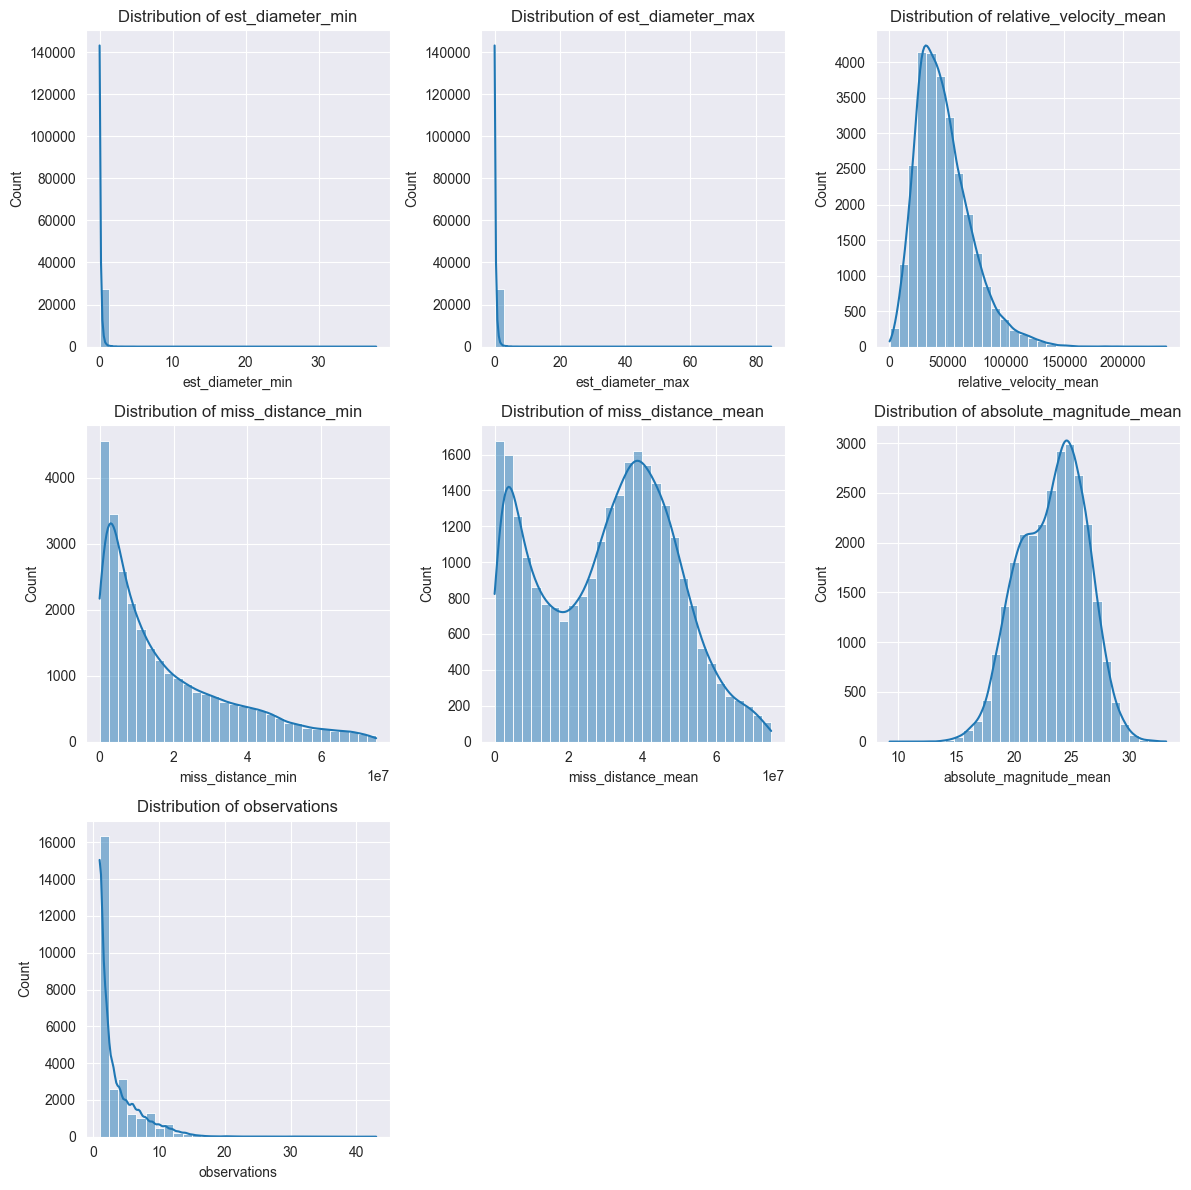

In [19]:
# --- Basic Distributions of Key Continuous Features ---
features = [
    "est_diameter_min", "est_diameter_max", "relative_velocity_mean",
    "miss_distance_min", "miss_distance_mean", "absolute_magnitude_mean",
    "observations"
]

plt.figure(figsize=(12, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(neo_features[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()



`absolute_magnitude_mean` and `relative_velocity_mean` are relatively normally distributed, though velocity has a wide range of values. 
Both values for miss_distance are not normally distributed and have a very wide range of values - changing these values to log scales will aid modelling and visualisation.
The same is true for both diameter values which are extremely skewed.
`observations` is also quite skewed, but the range of values is quite small.

A solution would be to convert the columns with wide range/ high degree of skewness a logarithmic scale. In addition I will add columns for the overall mean diameter of each column and the range of diameter (max - min). This will give an idea of the variance in shape between observations and a central value for diameter across observations.

In [20]:
#first create columns for diameter range and mean
neo_features['est_diameter_range'] = neo_features['est_diameter_max'] - neo_features['est_diameter_min']
neo_features['est_diameter_mean'] = (neo_features['est_diameter_max'] + neo_features['est_diameter_min']) / 2
neo_features.describe().T

,count,mean,std,min,25%,50%,75%,max
est_diameter_min,27423.0,1.390817e-01,3.744203e-01,0.000609,2.111324e-02,5.064715e-02,1.529519e-01,3.789265e+01
est_diameter_max,27423.0,3.109960e-01,8.372292e-01,0.001362,4.721065e-02,1.132505e-01,3.420109e-01,8.473054e+01
relative_velocity_mean,27423.0,4.682494e+04,2.335722e+04,646.320239,2.980754e+04,4.287564e+04,5.965196e+04,2.369901e+05
miss_distance_mean,27423.0,3.047301e+07,1.821554e+07,9316.925424,1.386736e+07,3.276135e+07,4.403119e+07,7.479865e+07
miss_distance_min,27423.0,1.770540e+07,1.724212e+07,6745.532516,4.121298e+06,1.145114e+07,2.710416e+07,7.479865e+07
absolute_magnitude_mean,27423.0,2.336167e+01,2.869921e+00,9.230000,2.120000e+01,2.360000e+01,2.550000e+01,3.320000e+01
observations,27423.0,3.312402e+00,3.408497e+00,1.000000,1.000000e+00,2.000000e+00,4.000000e+00,4.300000e+01
est_diameter_range,27423.0,1.719144e-01,4.628089e-01,0.000753,2.609741e-02,6.260332e-02,1.890590e-01,4.683789e+01
est_diameter_mean,27423.0,2.250388e-01,6.058247e-01,0.000985,3.416195e-02,8.194880e-02,2.474814e-01,6.131160e+01


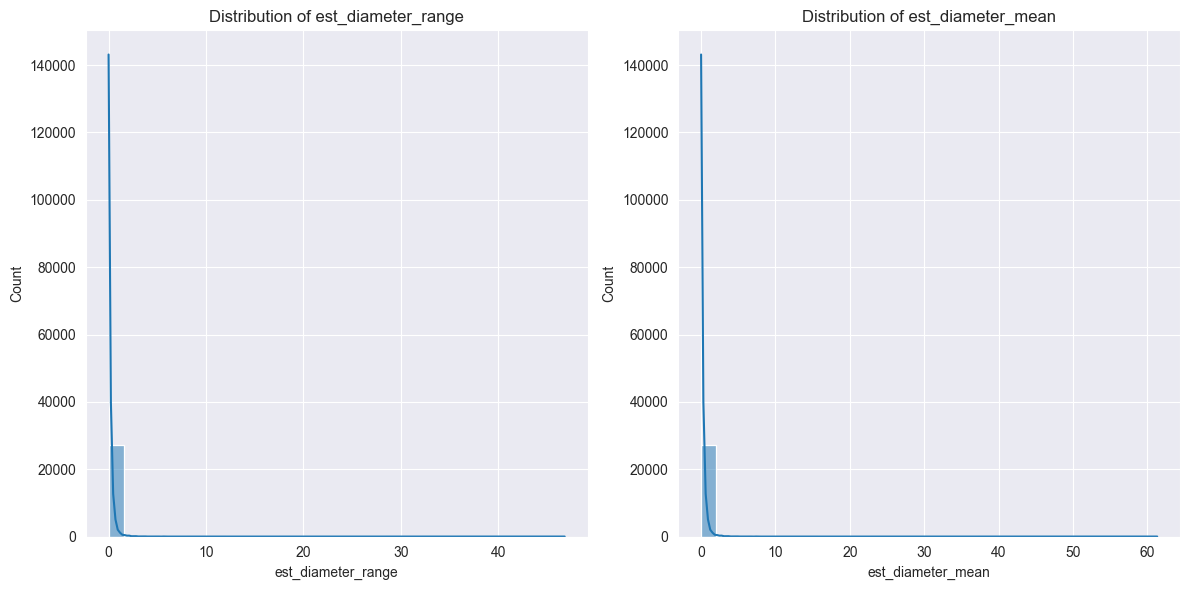

In [21]:
#plot distributions of new features
features = [
    "est_diameter_range", "est_diameter_mean"
]

plt.figure(figsize=(12, 6))
for i, col in enumerate(features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(neo_features[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Again these values are quite skewed. In order to mitigate this I will convert the following columns to log scale - this will reduce skewness, create a more normal distribution and reduce the influence of outliers. I will also keep the original columns for the following reasons;

1. I can use to explain results in the original scale (e.g., “distance in km”).

2. Flexibility: Some models (e.g., tree-based) handle raw scales fine, while others (e.g., linear regression) benefit from log scaling.

3. EDA insights: I can visualize both raw and log distributions to check for skewness or outliers.

4. Feature selection freedom: the decisions can be made whether to drop one based on feature importance or correlation.

In [22]:
#convert skewed columns to log scale
o_log1p = [
    'est_diameter_min', 'est_diameter_max', 'est_diameter_mean', 'est_diameter_range',
    'relative_velocity_mean', 'miss_distance_mean', 'miss_distance_min'
]

for c in o_log1p:
    neo_features[c + '_log1p'] = np.log1p(neo_features[c])
# Check the distribution of the log-transformed features
neo_features[['est_diameter_max_log1p','est_diameter_min_log1p','est_diameter_mean_log1p','est_diameter_range_log1p','miss_distance_mean_log1p','miss_distance_min_log1p']].describe().T

,count,mean,std,min,25%,50%,75%,max
est_diameter_max_log1p,27423.0,0.218788,0.274162,0.001361,0.046130,0.107284,0.294169,4.451209
est_diameter_min_log1p,27423.0,0.112828,0.162103,0.000609,0.020893,0.049406,0.142326,3.660805
est_diameter_mean_log1p,27423.0,0.168847,0.223967,0.000985,0.033591,0.078764,0.221127,4.132148
est_diameter_range_log1p,27423.0,0.135082,0.187499,0.000752,0.025763,0.060722,0.173162,3.867818
miss_distance_mean_log1p,27423.0,16.862554,1.126517,9.139695,16.445049,17.304760,17.600409,18.130310
miss_distance_min_log1p,27423.0,16.028162,1.391252,8.816784,15.231679,16.253600,17.115198,18.130310


The std measure for the new columns suggest a much more normal (and easier to interpret) distribution. Next we can check the distributions visually.

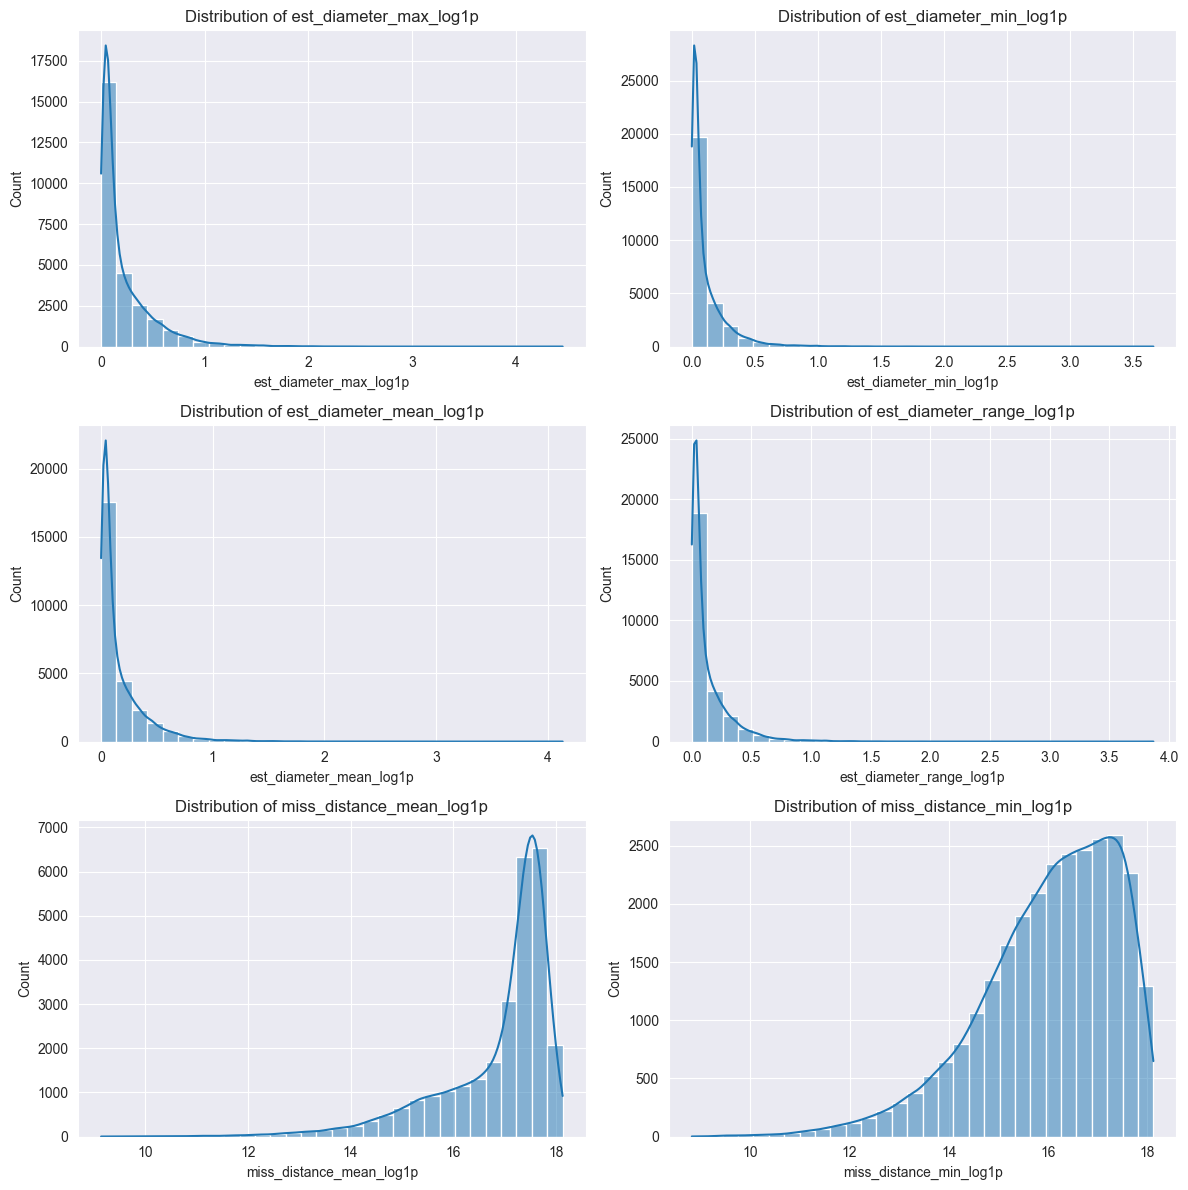

In [23]:
#plot distributions of new features
features = [
    'est_diameter_max_log1p','est_diameter_min_log1p','est_diameter_mean_log1p','est_diameter_range_log1p','miss_distance_mean_log1p','miss_distance_min_log1p',
]

plt.figure(figsize=(12, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(neo_features[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Finally we can check the columns in our dataset before processing

In [24]:
neo_features.dtypes, neo_features.shape

(name                             object
 est_diameter_min                float64
 est_diameter_max                float64
 relative_velocity_mean          float64
 miss_distance_mean              float64
 miss_distance_min               float64
 absolute_magnitude_mean         float64
 hazardous                          bool
 observations                      int64
 est_diameter_range              float64
 est_diameter_mean               float64
 est_diameter_min_log1p          float64
 est_diameter_max_log1p          float64
 est_diameter_mean_log1p         float64
 est_diameter_range_log1p        float64
 relative_velocity_mean_log1p    float64
 miss_distance_mean_log1p        float64
 miss_distance_min_log1p         float64
 dtype: object,
 (27423, 18))

In [25]:
neo_features.head()

,name,est_diameter_min,est_diameter_max,relative_velocity_mean,miss_distance_mean,miss_distance_min,absolute_magnitude_mean,hazardous,observations,est_diameter_range,est_diameter_mean,est_diameter_min_log1p,est_diameter_max_log1p,est_diameter_mean_log1p,est_diameter_range_log1p,relative_velocity_mean_log1p,miss_distance_mean_log1p,miss_distance_min_log1p
0,(1983 LC),0.342417,0.765667,60192.646491,1.847664e+07,1.033448e+07,19.45,True,2,0.423250,0.554042,0.294472,0.568529,0.440859,0.352943,11.005322,16.732018,16.150996
1,(1986 NA),0.284810,0.636854,51810.077045,7.005246e+07,7.005246e+07,19.85,False,1,0.352044,0.460832,0.250611,0.492776,0.379006,0.301618,10.855359,18.064755,18.064755
2,(1988 NE),0.402305,0.899580,22815.738845,6.506331e+07,6.506331e+07,19.10,False,1,0.497276,0.650942,0.338117,0.641633,0.501346,0.403647,10.035250,17.990871,17.990871
3,(1989 AZ),0.319562,0.714562,55184.046572,2.560466e+07,2.021980e+07,19.60,False,2,0.395000,0.517062,0.277300,0.539158,0.416776,0.332895,10.918447,17.058285,16.822173
4,(1991 GO),0.265800,0.594347,92501.896829,3.695728e+07,2.702563e+07,20.00,True,2,0.328547,0.430073,0.235704,0.466464,0.357726,0.284086,11.434995,17.425273,17.112296


---

# Loading

Now that our dataset is transformed we can proceed to saving our data. Two datasets will be saved:
* The original data (minus dropped columns) stored in df will be saved as observations.csv
    * Will be used in dashboard
* The new dataframe neo_features will be saved as features.csv
    * Will be used for statistical tests, modelling and dashboard

In [27]:
#save dataframes to csv files
df.to_csv('Data/Processed/observations.csv', index=False)
neo_features.to_csv('Data/Processed/features.csv', index=False)


# Conclusions

The initial dataset was essentially clean, but needed some feature engineering to aggregate data, add new columns and normalise data. The steps involved were:
* Loaded and profiled raw observations from neo.csv to confirm completeness and basic data quality.
* Aggregated observations to one row per object (neo_features) and dropped irrelevant columns for downstream analysis.
* Engineered key features: mean and range of estimated diameters, relative velocity summaries, miss-distance summaries, and observation counts.
* Added safe, non-destructive log-transformed copies (suffix _log1p) for heavily skewed continuous features to improve visualization and help linear models.
* Performed basic validation (dtypes, non-null counts, distribution checks) and saved outputs to features.csv and observations.csv.
* Next steps: run comparative EDA (raw vs log), finalize feature selection and scaling for modelling,